# Text Generation
Reddit ID, PW = stanfordruby[1-10]

In [1]:
import os
import json
import time
import nltk
import pickle
import numpy as np
import tensorflow as tf
import random
from random import randrange
from tqdm import tnrange, tqdm_notebook
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/john/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Context Unaware: Softmax LSTM

In [2]:
class ModelNetwork:
    def __init__(self, in_size, lstm_size, num_layers, out_size, session,
                 learning_rate=0.003, name="rnn"):
        self.scope = name
        self.in_size = in_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.out_size = out_size
        self.session = session
        self.learning_rate = tf.constant(learning_rate)
        # Last state of LSTM, used when running the network in TEST mode
        self.lstm_last_state = np.zeros(
            (self.num_layers * 2 * self.lstm_size,)
        )
        with tf.variable_scope(self.scope):
            # (batch_size, timesteps, in_size)
            self.xinput = tf.placeholder(
                tf.float32,
                shape=(None, None, self.in_size),
                name="xinput"
            )
            self.lstm_init_value = tf.placeholder(
                tf.float32,
                shape=(None, self.num_layers * 2 * self.lstm_size),
                name="lstm_init_value"
            )
            # LSTM
            self.lstm_cells = [
                tf.contrib.rnn.BasicLSTMCell(
                    self.lstm_size,
                    forget_bias=1.0,
                    state_is_tuple=False
                ) for i in range(self.num_layers)
            ]
            self.lstm = tf.contrib.rnn.MultiRNNCell(
                self.lstm_cells,
                state_is_tuple=False
            )
            # Iteratively compute output of recurrent network
            outputs, self.lstm_new_state = tf.nn.dynamic_rnn(
                self.lstm,
                self.xinput,
                initial_state=self.lstm_init_value,
                dtype=tf.float32
            )
            # Linear activation (FC layer on top of the LSTM net)
            self.rnn_out_W = tf.Variable(
                tf.random_normal(
                    (self.lstm_size, self.out_size),
                    stddev=0.01
                )
            )
            self.rnn_out_B = tf.Variable(
                tf.random_normal(
                    (self.out_size,), stddev=0.01
                )
            )
            outputs_reshaped = tf.reshape(outputs, [-1, self.lstm_size])
            network_output = tf.matmul(
                outputs_reshaped,
                self.rnn_out_W
            ) + self.rnn_out_B
            batch_time_shape = tf.shape(outputs)
            self.final_outputs = tf.reshape(
                tf.nn.softmax(network_output),
                (batch_time_shape[0], batch_time_shape[1], self.out_size)
            )
            # Training: provide target outputs for supervised training.
            self.y_batch = tf.placeholder(
                tf.float32,
                (None, None, self.out_size)
            )
            y_batch_long = tf.reshape(self.y_batch, [-1, self.out_size])
            self.cost = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(
                    logits=network_output,
                    labels=y_batch_long
                )
            )
            self.train_op = tf.train.RMSPropOptimizer(
                self.learning_rate,
                0.9
            ).minimize(self.cost)

    # Input: X is a single element, not a list!
    def run_step(self, x, init_zero_state=True):
        # Reset the initial state of the network.
        if init_zero_state:
            init_value = np.zeros((self.num_layers * 2 * self.lstm_size,))
        else:
            init_value = self.lstm_last_state
        out, next_lstm_state = self.session.run(
            [self.final_outputs, self.lstm_new_state],
            feed_dict={
                self.xinput: [x],
                self.lstm_init_value: [init_value]
            }
        )
        self.lstm_last_state = next_lstm_state[0]
        return out[0][0]

    # xbatch must be (batch_size, timesteps, input_size)
    # ybatch must be (batch_size, timesteps, output_size)
    def train_batch(self, xbatch, ybatch):
        init_value = np.zeros(
            (xbatch.shape[0], self.num_layers * 2 * self.lstm_size)
        )
        cost, _ = self.session.run(
            [self.cost, self.train_op],
            feed_dict={
                self.xinput: xbatch,
                self.y_batch: ybatch,
                self.lstm_init_value: init_value
            }
        )
        return cost


def embed_to_vocab(data_, vocab):
    """
    Embed string to character-arrays -- it generates an array len(data)
    x len(vocab).
    Vocab is a list of elements.
    """
    data = np.zeros((len(data_), len(vocab)))
    cnt = 0
    for s in data_:
        v = [0.0] * len(vocab)
        v[vocab.index(s)] = 1.0
        data[cnt, :] = v
        cnt += 1
    return data


def decode_embed(array, vocab):
    return vocab[array.index(1)]

def compute_perplexity(loss):
    return tf.exp(loss)


def load_data(inputs):
    # Load the data
    data_ = []
    startwords = set()
    charlens = list()
    count = 0
    for i in tnrange(len(inputs)):
        input = inputs[i]
        print("Loading {}".format(input))
        with open(input, 'r') as f:
            for i, line in enumerate(f, 1):
                count += 1
                raw = json.loads(line)
                comment = nltk.word_tokenize(raw["body"])
                data_ += comment
                if (len(comment)>0):
                    charlens.append(len(raw["body"]))
                    startwords.add(comment[0])
#                 data_ += comment["body"]
#                 charlens.append((len(comment["body"])))
#                 startwords.add(nltk.word_tokenize(comment["body"])[0])
                if count % 1000000 == 0:
                    print ("Processed {} lines".format(count))
    startwords = list(startwords)    
    data_ = data_
    # Convert to 1-hot coding
    vocab = sorted(list(set(data_)))
    data = embed_to_vocab(data_, vocab)
    return data, vocab, startwords, charlens

def check_restore_parameters(sess, saver):
    """ Restore the previously trained parameters if there are any. """
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('saved/checkpoint'))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

In [7]:
# def generate(input_files, config):
def generate(input_files, config, data, vocab, startwords, charlens):
    ckpt_file = "saved/model.ckpt"

#     print("Loading Data")
#     data, vocab, startwords, charlens = load_data(input_files)
    print("Loading Config")
    prefix = random.sample(startwords, 1)
    in_size = out_size = len(vocab)
    
    lstm_size = config["lstm_size"]
    learning_rate = config["lr_rate"]
    num_layers = config["num_layers"]
    batch_size = config["batch_size"]
    time_steps = config["time_steps"]
    NUM_TRAIN_BATCHES = config["NUM_TRAIN_BATCHES"]

    print("Config Loaded")
    # Number of test characters of text to generate after training the network
    LEN_TEST_TEXT = int(np.random.normal(np.mean(charlens),np.std(charlens)/2.0))

    # Initialize the network
    print("Initializaing Network")
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.InteractiveSession(config=config)
    net = ModelNetwork(
        in_size=in_size,
        lstm_size=lstm_size,
        learning_rate=learning_rate,
        num_layers=num_layers,
        out_size=out_size,
        session=sess,
        learning_rate=0.003,
        name="char_rnn_network"
    )
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(tf.global_variables())
    
    # 1. TRAIN THE NETWORK
    # check_restore_parameters(sess, saver)
    print("Trining Network")
    last_time = time.time()
    batch = np.zeros((batch_size, time_steps, in_size))
    batch_y = np.zeros((batch_size, time_steps, in_size))
    possible_batch_ids = range(data.shape[0] - time_steps - 1)

    for i in tnrange(NUM_TRAIN_BATCHES):
        # Sample time_steps consecutive samples from the dataset text file
        batch_id = random.sample(possible_batch_ids, batch_size)

        for j in range(time_steps):
            ind1 = [k + j for k in batch_id]
            ind2 = [k + j + 1 for k in batch_id]

            batch[:, j, :] = data[ind1, :]
            batch_y[:, j, :] = data[ind2, :]

        cst = net.train_batch(batch, batch_y)

        if (i % 100) == 0:
            new_time = time.time()
            diff = new_time - last_time
            last_time = new_time
            print(
                "batch: {}  loss: {}  speed: {} batches / s".format(
                    i, cst, 100 / diff
                )
            )
            saver.save(sess, ckpt_file)

    # 2) GENERATE LEN_TEST_TEXT CHARACTERS USING THE TRAINED NETWORK
    saver.restore(sess, ckpt_file)
    
    print("Generating Comment")
    TEST_PREFIX = prefix
#     TEST_PREFIX = TEST_PREFIX.lower()
    for i in range(len(TEST_PREFIX)):
        print(TEST_PREFIX[i])
        out = net.run_step(embed_to_vocab([TEST_PREFIX[i]], vocab), i == 0)

    print("Sentence:")
    gen_str = TEST_PREFIX[0]
    print(gen_str)
    for i in range(LEN_TEST_TEXT):
        element = np.random.choice(range(len(vocab)), p=out)
        gen_str += ' ' + vocab[element]
        out = net.run_step(embed_to_vocab([vocab[element]], vocab), False)

    print(gen_str)

In [4]:
# Run genPrep.py [year] [month] or genBatchPrep.py [year]
# Run genPrepWrap.py
# Run genExtract.py [year] [month] or genBatchExtract.py [year]

In [ ]:
import os
files = []

# subreddits = ["announcements", "funny", "AskReddit", "todayilearned", "science", "worldnews",
#          "pics", "IAmA", "gaming", "videos", "movies", "aww", "Music", "blog", "gifs",
#          "news", "explainlikeimfive", "askscience", "EarthPorn", "books"]
# features = ["nc20","nc30","sc1000","ct2000"]
subreddits = ["funny"]
features = ["nc30"]
path = "data/"

for s in subreddits:
    for f in features:
        for year in range(13):
            for month in range(12):
                y = 2005 + year
                y = 2016
                m = 1 + month
                if m < 10: 
                    m = "0" + str(m)
                filename = path + str(y) + str(m) + "target" + s + f +".json"
                if os.path.isfile(filename):
                    files.append(filename)
print(len(files))
                    
config = {
    "lr_rate" : 0.003,
    "lstm_size" : 256,
    "num_layers" : 4,
    "batch_size" : 128,
    "time_steps" : 1000,
    "NUM_TRAIN_BATCHES" : 50000,
}

print("Loading Data")
data, vocab, startwords, charlens = load_data(files)

files = [data, vocab, startwords, charlens]
filenames = ["data", "vocab", "startwords", "charlens"]
for i in range(len(filenames)):
    with open(filenames[i] + '.p', 'wb') as fp:
        pickle.dump(files[i], fp)
        print ("Saved {} Pickle".format(filenames[i]))

156
Loading Data


A Jupyter Widget

In [ ]:
data, vocab, startwords, charlens = [], [], [], []
files = [data, vocab, startwords, charlens]
filenames = ["data", "vocab", "startwords", "charlens"]
for i in range(len(filenames)):
    with open(filenames[i] + '.p', 'rb') as fp:
        files[i] = pickle.load(fp)
        print ("Loaded {} pickle".format(filenames[i]))

generate(files, config, data, vocab, startwords, charlens)

# Results Analysis

In [16]:
results = dict()

for sub in ["funny", "news", "todayilearned", "pics", "aww", "books", "gaming"]:
    for fea in ["nc30", "sc1000", "ct2000"]:
        for bs in [32, 16, 4]:
            for nb in [1000, 10000, 100000, 1000000]:
                for ts in [10, 40, 160]:
                    for nl in [2, 4, 8]:
                        for lr in [0.3, 0.003, 0.00003]:
                            savefile = "results/{}-{}-{}-{}-{}-{}-{}".format(sub, fea, lr, nl, bs, nb, ts)
                            if os.path.isfile(savefile+'.csv'):
                                csvdata = np.genfromtxt(savefile+'.csv', delimiter=',')
                                line = csvdata[-1:][0]
#                                 print(savefile)
#                                 print(line)
                                for x in [sub, fea, bs, nb, ts, nl, lr]:
                                    if x not in results.keys():
                                        results[x] = []
                                    results[x].append(line)

[  9.99000000e+03   2.01345000e+01   5.55004000e+08   3.48213927e-05]


In [71]:
for x in ["funny", "news", "todayilearned", "pics", "aww", "books", "gaming"]:
    lines = results[x]
    count = 0
    pp = 0
    for line in lines:
        if pp != float('inf'):
            print(pp)
            pp += line[2]
            count += 1
#     print(x)
#     print(len(lines))
#     print(pp/count)

0
nan
nan
nan
nan
nan
0
1680.42
2514.073
0
0
0
0
0


In [60]:
for x in ["nc30", "sc1000", "ct2000"]:
    if x in results.keys():
        lines = results[x]
        count = 0
        for line in lines:
            pp = line[2]
            count += 1
        print(x)
        print(len(lines))
        print(pp/count)

nc30
15
62.6522666667
sc1000
20
33.9767


In [61]:
for x in [32, 16, 4]:
    if x in results.keys():
        lines = results[x]
        count = 0
        for line in lines:
            pp = line[2]
            count += 1
        print(x)
        print(len(lines))
        print(pp/count)

32
35
19.4152571429


In [62]:
for x in [1000, 10000, 100000, 1000000]:
    if x in results.keys():
        lines = results[x]
        count = 0
        for line in lines:
            pp = line[2]
            count += 1
        print(x)
        print(len(lines))
        print(pp/count)

1000
35
19.4152571429


In [63]:
for x in [10, 40, 160]:
    if x in results.keys():
        lines = results[x]
        count = 0
        for line in lines:
            pp = line[2]
            count += 1
        print(x)
        print(len(lines))
        print(pp/count)

160
35
19.4152571429


In [74]:
for x in [1, 2, 4, 8]:
    if x in results.keys():
        lines = results[x]
        count = 0
        pp = 0
        for line in lines:
            pp = line[2]
            count += 1
        print(x)
        print(len(lines))
        print(pp/count)

8
35
19.4152571429


In [67]:
for x in [0.3, 0.003, 0.00003]:
    if x in results.keys():
            lines = results[x]
            count = 0
            pp = 0
            for line in lines:
                pp += line[2]
                count += 1
            print(x)
            print(len(lines))
            print(pp/count)

0.3
12
nan
0.003
12
799.275833333
3e-05
11
793.250636364


In [36]:
results = dict()

for sub in ["funny", "news", "todayilearned", "pics", "aww", "books", "gaming"]:
    for fea in ["nc30", "sc1000", "ct2000"]:
        for bs in [32, 16, 4]:
            for nb in [1000, 10000, 100000, 1000000]:
                for ts in [10, 40, 160]:
                    for nl in [2, 4, 8]:
                        for lr in [0.3, 0.003, 0.00003]:
                            savefile = "results/{}-{}-{}-{}-{}-{}-{}".format(sub, fea, lr, nl, bs, nb, ts)
                            if os.path.isfile(savefile+'.txt'):
                                with open(savefile+'.txt', 'r') as inFile:
                                    for i, line in enumerate(inFile, 1):
                                        print(savefile)
                                        print(line)
                                print('\n')


results/funny-nc30-0.003-8-32-1000-160
God the the about man the creativity my her for the created been a the edit rankle just the dynamic our get you love our not di t i something naming i have sensible it over cell people sent to her spamming is off it com if doing pro scifi


results/funny-nc30-3e-05-8-32-1000-160
Exactly cut gu picture as holder something they be the any any


results/funny-nc30-0.3-2-32-10000-10
Er kidnaps braden s had s you not it unpermitted far shot action to and gt going now night right be it credits t that learn giant kidding you hillary t the


results/funny-nc30-0.003-2-32-10000-10
Mortgage


results/funny-sc1000-0.003-8-32-1000-160
Lol opinion gold you this into such comedy both out hear and than what shirts it lol pictures image hurt dessert term to the his in imgur over gif backstory the than d a just s make tanning get inappropriate a and back s like body talk know put those fish reality com this nobody it channel near c warrior is santa handwrite a its

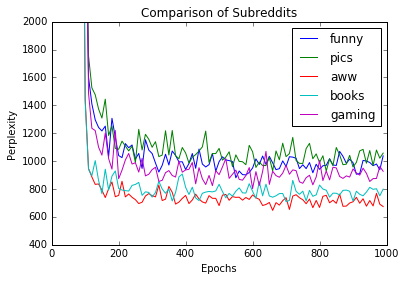

In [91]:
import matplotlib.pyplot as plt

results = dict()

for sub in ["funny", "news", "todayilearned", "pics", "aww", "books", "gaming"]:
#     for fea in ["nc30", "sc1000"]:
    for fea in ["nc30"]:
        for bs in [32]:
#             for nb in [1000, 10000, 100000, 1000000]:
            for nb in [1000]:
                for ts in [160]:
#                     for nl in [1, 2, 4, 8]:
                    for nl in [8]:
#                         for lr in [0.3, 0.003, 0.00003]:
                        for lr in [0.003]:
                            savefile = "results/{}-{}-{}-{}-{}-{}-{}".format(sub, fea, lr, nl, bs, nb, ts)
                            if os.path.isfile(savefile+'.csv'):
                                csvdata = np.genfromtxt(savefile+'.csv', delimiter=',')
                                for key in [sub, fea, bs, nb, ts, nl, lr]:
                                    if key not in results.keys():
                                        results[key] = []
                                    results[key].append(csvdata[-1:][0])
                                x, y = [], []
                                for line in csvdata:
                                    x.append(line[0])
                                    y.append(line[2])
                                plt.plot(x, y, label=sub)
plt.title("Comparison of Subreddits")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.axis([0, 1000, 400, 2000])
plt.legend()
plt.show()

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


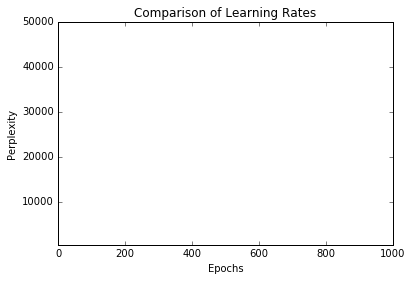

In [102]:
import matplotlib.pyplot as plt

results = dict()

for sub in ["funny"]:
    for fea in ["nc30"]:
        for bs in [32, 16]:
#             for nb in [1000, 10000, 100000, 1000000]:
            for nb in [1000]:
                for ts in [160]:
                    for nl in [1, 2, 4, 8]:
#                     for nl in [8]:
                        for lr in [0.003]:
                            savefile = "results/{}-{}-{}-{}-{}-{}-{}".format(sub, fea, lr, nl, bs, nb, ts)
                            if os.path.isfile(savefile+'.csv'):
                                csvdata = np.genfromtxt(savefile+'.csv', delimiter=',')
                                for key in [sub, fea, bs, nb, ts, nl, lr]:
                                    if key not in results.keys():
                                        results[key] = []
                                    results[key].append(csvdata[-1:][0])
                                x, y = [], []
                                for line in csvdata:
                                    x.append(line[0])
                                    y.append(line[2])
                                plt.plot(x, y, label=nl)
plt.title("Comparison of Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.axis([0, 1000, 400, 50000])
plt.legend()
plt.show()

In [123]:
# import os
# import csv
# import sys
# import json
# import time
# import nltk
# import pickle
# import random
# import numpy as np
# import collections
# import tensorflow as tf
# from random import randrange
# from tqdm import tnrange, tqdm_notebook
# from operator import itemgetter
# from nltk.tokenize import RegexpTokenizer
# from nltk.corpus import stopwords

# nltk.download("punkt")
# nltk.download("stopwords")
# stopWords = set(stopwords.words('english'))


# files = []
# subreddits = ["announcements", "funny", "AskReddit", "todayilearned", "science", "worldnews", "pics", "IAmA", "gaming", "videos", "movies", "aww", "Music", "blog", "gifs", "news", "explainlikeimfive", "askscience", "EarthPorn", "books"]   
# features = ["nc20","nc30","sc1000","ct2000"]                                
# path = "target/"

# print("Building File List")
# for s in subreddits:
#     for f in features:
#         for year in range(13):
#             for month in range(12):
#                 y = 2005 + year
#                 m = 1 + month
#                 if m < 10:
#                     m = "0" + str(m)
#                 filename = path + str(y) + str(m) + "target" + s + f +".json"
#                 if os.path.isfile(filename) and filename not in files:
#                     files.append(filename)

# print("Reading Files")
# vocab = dict()
# tokenizer = RegexpTokenizer(r'[A-Za-z]+')
# linecount = 0
# for i in tnrange(len(files)):
#     file = files[i]
#     with open(file, 'r') as inFile:
#         for i, line in enumerate(inFile, 1):
#             linecount += 1
#             raw = json.loads(line)
#             comment = tokenizer.tokenize(raw["body"])
#             for word in comment:
#                 if word not in vocab.keys():
#                     vocab[word] = 0
#                 vocab[word] += 1

# print(stopWords)

print("Printing Information")
print("Number of comments: {}".format(linecount))
print("Vocabulary size: {}".format(len(vocab.keys())))
print("Most Frequent Words")
vocabulary = [(v,k) for k,v in vocab.items()]
vocabulary.sort(reverse=True)
limit = 20
topstopwords = []
for i in range(len(vocabulary)):
    v, k = vocabulary[i]
    if i == limit: break
    topstopwords.append(k)
print(topstopwords)

topwords = []
print("Most Frequent None-Stop-Words")
for i in tnrange(len(vocabulary)):
    v, k = vocabulary[i]
    if k.lower() not in stopWords:
        print(k)
        if len(topwords) == 40: break
        topwords.append(k)
print(topwords)

Printing Information
Number of comments: 17941413
Vocabulary size: 1544449
Most Frequent Words
['the', 'to', 'a', 'I', 'and', 'of', 'it', 'that', 'in', 'is', 'you', 's', 't', 'on', 'for', 'was', 'with', 'have', 'are', 'be']
Most Frequent None-Stop-Words


A Jupyter Widget

I
like
one
people
The
It
would
beer
bottles
get
time
You
http
think
wall
know
com
around
really
great
gt
If
even
This
That
make
much
could
go
way
He
see
want
They
going
good
And
never
still
back
something

['I', 'like', 'one', 'people', 'The', 'It', 'would', 'beer', 'bottles', 'get', 'time', 'You', 'http', 'think', 'wall', 'know', 'com', 'around', 'really', 'great', 'gt', 'If', 'even', 'This', 'That', 'make', 'much', 'could', 'go', 'way', 'He', 'see', 'want', 'They', 'going', 'good', 'And', 'never', 'still', 'back']
